# 1. Defining the Data Science problem here (v2)
---
>**This project's data science problem is to build a model that will predict the price of a house at sale in Ames, Iowa before a sale.**
<br>The final model selected here is a MLR with 3 features capturing: **Area, Age and Quality datapoints.**
<br>Included in this notebook includes models built on:
    - Single Linear Regression
    - Lasso Regression
    - Ridge Regression
    - Elastic Net

Despite some of the other models offering better predictive powers, the MLR was selected because of it is easy to simple to understand and to explain to other stakeholders such as realtors or house owners that might have an interest in this problem. It is not easy to explain a model with 30 predictors.

The model created here is created using a regression model based on the [Ames Housing Dataset](https://www.kaggle.com/c/dsi-us-6-project-2-regression-challenge).

The data dictionary for the dataset could be found [here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt).
<br>
<br>The limitation of the models created here include:
    - will need to modify the age calculation used (2010 - year of remod)
    - unable to accurately predict large houses
    - houses with unique characteristics such as missing sewarage, no central aircon etc as there are not 
    enough samples to predict accurartely
    - like many models, this is not an evergreen model.. 

# Changelog from v1 in bold

- [2. Gathering the data](#2.-Gathering-the-data)

- [3. Exploring and cleaning the data](#3.-Exploring-and-cleaning-the-data)
        - Filling of null data
        - Dropping of rows with lots of missing data
        
- 4. Exploratory Data Plots                       **removed**
        - Scatterplot
        - Histogram
        - Boxplot
        - dropping of big outliers
        
- 5. Baseline model creation                      **removed**
        - Plotting of heatmap 
        - Construction of SLR
        
- 6. Our simple 3 variable Multi Linear Regressor **removed**
        - Construction of MLR


- [**Using heatmap to do advanced filtering first**](#Using-heatmap-to-do-advanced-filtering-first)  **NEW**
        - Using heatmap to do advanced filtering first
        - drop super correlated features
        
- [7. Embedded method of feature selection](#7.-Embedded-method-of-feature-selection) **Different results**
        - Lasso Regression
        - Ridge Regression
        - Feature selection

- [8. Conclusion](#8.-Conclusion)
        - Choice of model      

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline

<a id='2.-Gathering-the-data'></a>
# 2. Gathering the data

**Data is provided here**


In [2]:
# load the training set
train = pd.read_csv('datasets/train.csv')

<a id='3.-Exploring-and-cleaning-the-data'></a>
# 3. Exploring and cleaning the data

In [3]:
# Using the .info to have a glance at the dtype, missing values etc
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         20

Based on the info above, there are missing values to be fixed and I also went to cross-check against the data dictionary to make sure there dtypes are correct. 

- `MS SubClass` is categorical despite being int64 and it is a combination of a few features such as area and year. Will fix it to convert into a `string`.
- Decided to drop `PID` since they will not affect price, retain Id and reset it to be the index.


In [4]:
# drop PID column
train.drop(columns=['PID'],inplace=True)

In [5]:
# resetting index to use Id as index
train.set_index(keys='Id',inplace=True)

In [6]:
# Fix MS Subclass so that it can be 1 hot encoded later
train['MS SubClass'] = train['MS SubClass'].apply(lambda x: str(x))

In [7]:
# sum of isnull() is better than manual calculation
train.isnull().sum().sort_values(ascending=False)

Pool QC            2042
Misc Feature       1986
Alley              1911
Fence              1651
Fireplace Qu       1000
Lot Frontage        330
Garage Qual         114
Garage Cond         114
Garage Yr Blt       114
Garage Finish       114
Garage Type         113
Bsmt Exposure        58
BsmtFin Type 2       56
Bsmt Qual            55
BsmtFin Type 1       55
Bsmt Cond            55
Mas Vnr Type         22
Mas Vnr Area         22
Bsmt Half Bath        2
Bsmt Full Bath        2
Bsmt Unf SF           1
Total Bsmt SF         1
BsmtFin SF 1          1
BsmtFin SF 2          1
Garage Cars           1
Garage Area           1
Exterior 2nd          0
Exterior 1st          0
Roof Matl             0
Roof Style            0
                   ... 
Condition 2           0
Heating QC            0
Foundation            0
Heating               0
Yr Sold               0
Mo Sold               0
Misc Val              0
Pool Area             0
Screen Porch          0
3Ssn Porch            0
Enclosed Porch  

Based on the data dictionary. Here's my thinking:

**1.** `NA` is causing null values in: `Pool QC`,`Misc Feature`,`Alley`,`Fence`,`Fireplace Qu`,`Lot Frontage`,`Garage Qual`, `Garage Cond`,`Garage Yr Blt`,`Garage Finish`,`Garage Type`,`Bsmt Exposure`,`BsmtFin Type 2`,`Bsmt Qual`,`BsmtFin Type 1`, `Bsmt Cond`,`Mas Vnr Type`,`Mas Vnr Area`, `Bsmt Half Bath`,`Bsmt Full Bath`, `Bsmt Unf SF`, `Total Bsmt SF`, `BsmtFin SF 1`, `BsmtFin SF 2`, `Garage Cars` & `Garage Area`.<p>

**2.** Some features maybe combined?
- `Year Built` and `Year Remod/Add` maybe can combined or replaced for 1 another ???
- `Exterior 1` &  `Exterior 2`'s `AsbShng` is Asbestos which is cancer-causing might have impact on price?<p>

**3.** Some of the null values maybe related?
- `Mas Vnr Type`'s None/NA causing null values?
- `Mas Vnr Area`'s missing values caused by the above's null?
- `Garage Type`'s None/NA causing null? 
- `Garage Yr Blt`'s null maybe due to above?
- `Misc Feature`'s None/NA causing null in categorical?
- `Misc Val`'s null related to above?


In [8]:
# added pd.set_option('display.max_columns', 100) on top to see the truncated columns.
# see alot of data points with 0 for min, 25%, 50% and 75% percentile.
train.describe()

,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,2050.000000,2050.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2049.000000,2049.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,1937.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,442.300488,47.959024,567.728293,1057.987805,1164.488055,329.329108,5.512921,1499.330083,0.427526,0.063446,1.577279,0.371039,2.843491,1.042906,6.435885,0.590931,1978.707796,1.776585,473.671707,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,461.204124,165.000901,444.954786,449.410704,396.446923,425.671046,51.068870,500.447829,0.522673,0.251705,0.549279,0.501043,0.826618,0.209790,1.560225,0.638516,25.441094,0.764537,215.934561,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,220.000000,793.000000,879.500000,0.000000,0.000000,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.500000,994.500000,1093.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,733.750000,0.000000,811.000000,1318.750000,1405.000000,692.500000,0.000000,1728.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,5095.000000,1862.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


### Filling the null values

**1.** filled categorical with 'N.A' <p>

**2.** made use of relational fields to cross check ie `Mas Vnr Type` & `Mas Vnr Area`.

In [9]:
# For Categorical Alley that can be just filled.

train['Alley'].fillna('N.A',inplace=True)
train['Fence'].fillna('N.A',inplace=True)

# Fill this 2 since they are related and None is the mode of the data.
train['Mas Vnr Type'].fillna(str('None'),inplace=True)
train['Mas Vnr Area'].fillna(0,inplace=True)

# Fill this discrete
train['Lot Frontage'].fillna(0,inplace=True)

In [10]:
# check relational fileds and filling data.
# Pool Area has 0 filled.

print(train['Pool Area'].value_counts().get(0))
print(train['Pool QC'].isnull().sum())
# count of 0 show the same number of missing value of Pool QC.
train['Pool QC'].fillna('N.A',inplace=True)

2042
2042


In [11]:
print(train['Misc Val'].value_counts().get(0))
print(train['Misc Feature'].isnull().sum())

# count of 0 show the same number of missing value of Misc Feature .
train['Misc Feature'].fillna('N.A',inplace=True)

1986
1986


In [12]:
print(train['Fireplaces'].value_counts().get(0))
print(train['Fireplace Qu'].isnull().sum())

# count of 0 show the same number of missing value of Fireplace Qu.
train['Fireplace Qu'].fillna('N.A',inplace=True)

1000
1000


In [13]:
train.isnull().sum().sort_values(ascending=False).head(20)

Garage Qual       114
Garage Cond       114
Garage Yr Blt     114
Garage Finish     114
Garage Type       113
Bsmt Exposure      58
BsmtFin Type 2     56
BsmtFin Type 1     55
Bsmt Cond          55
Bsmt Qual          55
Bsmt Half Bath      2
Bsmt Full Bath      2
Garage Area         1
Garage Cars         1
Total Bsmt SF       1
Bsmt Unf SF         1
BsmtFin SF 2        1
BsmtFin SF 1        1
Exterior 1st        0
Mas Vnr Type        0
dtype: int64

In [14]:
# carve out a smaller subset to reduce the num of columns to display
outlier_garagecar = train[['Garage Type','Garage Qual','Garage Cond','Garage Yr Blt','Garage Finish','Garage Cars','Garage Area']]
display(outlier_garagecar[(outlier_garagecar['Garage Cars'].isnull())])

# empty Cars and Area belong to same row but type is Detchd.

# real missing data. - decide to drop
train.drop(2237,inplace=True)

,Garage Type,Garage Qual,Garage Cond,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area
Id,,,,,,,
2237,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# fill up the Garage related after dropping missing data cell.

train['Garage Finish'].fillna('N.A',inplace=True)
train['Garage Qual'].fillna('N.A',inplace=True)
train['Garage Cond'].fillna('N.A',inplace=True)
train['Garage Type'].fillna('N.A',inplace=True)
train['Garage Yr Blt'].fillna(0,inplace=True)

In [16]:
# time to fix bsmt
train.isnull().sum().sort_values(ascending=False).head(20)

Bsmt Exposure     58
BsmtFin Type 2    56
Bsmt Qual         55
BsmtFin Type 1    55
Bsmt Cond         55
Bsmt Full Bath     2
Bsmt Half Bath     2
Total Bsmt SF      1
Bsmt Unf SF        1
BsmtFin SF 1       1
BsmtFin SF 2       1
Foundation         0
Exter Cond         0
Exter Qual         0
Mas Vnr Area       0
Mas Vnr Type       0
Exterior 2nd       0
Exterior 1st       0
Roof Matl          0
Roof Style         0
dtype: int64

In [17]:
# same as earlier to subset a smaller set for reading the columns
outlier_bsmt = train[['Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin SF 1','BsmtFin Type 2','BsmtFin SF 2','Bsmt Full Bath','Bsmt Half Bath','Bsmt Unf SF','Total Bsmt SF']]

In [18]:
outlier_bsmt[(outlier_bsmt['BsmtFin SF 1'].isnull())]
# to check for the id of missing, also happens to be missing SF 2 and Unf

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Full Bath,Bsmt Half Bath,Bsmt Unf SF,Total Bsmt SF
Id,,,,,,,,,,,
1342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# def a funct to fix the data in bsmt in the train df and the smaller viewing subset
def checknfill(rowid):
    for i in outlier_bsmt.select_dtypes(include='object').columns:
        outlier_bsmt.loc[rowid,i] = 'N.A'
        train.loc[rowid,i] = 'N.A'
    for i in outlier_bsmt.select_dtypes(exclude='object').columns:
        outlier_bsmt.loc[rowid,i] = 0
        train.loc[rowid,i] = 0

In [20]:
# fill up Id 1342 because the cat of Bsmt is NA hence just fill all N.A and 0 across the row.
checknfill(1342)

C:\Users\himyn\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [21]:
outlier_bsmt[(outlier_bsmt['Bsmt Full Bath'].isnull())]
# id 1498 also no basement and some other partial fill

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Full Bath,Bsmt Half Bath,Bsmt Unf SF,Total Bsmt SF
Id,,,,,,,,,,,
1498,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0


In [22]:
checknfill(1498)

In [23]:
#use the intercept of Cond and Qual and fill
intercept = outlier_bsmt[(outlier_bsmt['Bsmt Cond'].isnull()) & (outlier_bsmt['Bsmt Qual'].isnull())]

for i in intercept.index:
    checknfill(i)

In [24]:
display(outlier_bsmt.isnull().sum())

# last 2 columns to fix

Bsmt Qual         0
Bsmt Cond         0
Bsmt Exposure     3
BsmtFin Type 1    0
BsmtFin SF 1      0
BsmtFin Type 2    1
BsmtFin SF 2      0
Bsmt Full Bath    0
Bsmt Half Bath    0
Bsmt Unf SF       0
Total Bsmt SF     0
dtype: int64

In [25]:
outlier_bsmt = outlier_bsmt[(outlier_bsmt['Bsmt Exposure'].isnull())]

for i in outlier_bsmt.index:
    checknfill(i)

In [26]:
# real missing data. - decide to drop
train.drop(445,inplace=True)

In [27]:
# No more missing data.
train.isnull().sum().sort_values(ascending=False).head(5)

SalePrice       0
Foundation      0
Roof Matl       0
Exterior 1st    0
Exterior 2nd    0
dtype: int64


**Managed to fill the missing data points and dropped only 2 rows of data.**


**Dropping the outlier data**

In [28]:
train[(train['Lot Area'] > 100000)]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2116,50,RL,0.0,159000,Pave,N.A,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1.5Fin,6,7,1958,2006,Gable,CompShg,Wd Sdng,HdBoard,BrkCmn,472.0,Gd,TA,CBlock,Gd,TA,Gd,Rec,697.0,Unf,0.0,747.0,1444.0,GasA,Gd,Y,SBrkr,1444,700,0,2144,0.0,1.0,2,0,4,1,Gd,7,Typ,2,TA,Attchd,1958.0,Fin,2.0,389.0,TA,TA,Y,0,98,0,0,0,0,N.A,N.A,Shed,500,6,2007,WD,277000
2072,20,RL,0.0,115149,Pave,N.A,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,5,1971,2002,Gable,CompShg,Plywood,Plywood,Stone,351.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,1219.0,Unf,0.0,424.0,1643.0,GasA,TA,Y,SBrkr,1824,0,0,1824,1.0,0.0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1971.0,Unf,2.0,739.0,TA,TA,Y,380,48,0,0,0,0,N.A,N.A,N.A,0,6,2007,WD,302000


In [29]:
train[(train['Gr Liv Area'] > 5000)]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1499,60,RL,313.0,63887,Pave,N.A,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644.0,Unf,0.0,466.0,6110.0,GasA,Ex,Y,SBrkr,4692,950,0,5642,2.0,0.0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2.0,1418.0,TA,TA,Y,214,292,0,0,0,480,Gd,N.A,N.A,0,1,2008,New,160000
2181,20,RL,128.0,39290,Pave,N.A,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,N.A,N.A,Elev,17000,10,2007,New,183850


In [30]:
train[(train['BsmtFin SF 1'] > 3500)]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1499,60,RL,313.0,63887,Pave,N.A,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644.0,Unf,0.0,466.0,6110.0,GasA,Ex,Y,SBrkr,4692,950,0,5642,2.0,0.0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2.0,1418.0,TA,TA,Y,214,292,0,0,0,480,Gd,N.A,N.A,0,1,2008,New,160000
2181,20,RL,128.0,39290,Pave,N.A,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,N.A,N.A,Elev,17000,10,2007,New,183850


In [31]:
train[(train['Total Bsmt SF'] > 4000)]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1499,60,RL,313.0,63887,Pave,N.A,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644.0,Unf,0.0,466.0,6110.0,GasA,Ex,Y,SBrkr,4692,950,0,5642,2.0,0.0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2.0,1418.0,TA,TA,Y,214,292,0,0,0,480,Gd,N.A,N.A,0,1,2008,New,160000
2181,20,RL,128.0,39290,Pave,N.A,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,N.A,N.A,Elev,17000,10,2007,New,183850


In [32]:
train[(train['Wood Deck SF'] > 1400)]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2294,80,RL,0.0,15957,Pave,N.A,IR1,Low,AllPub,Corner,Mod,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1977,1977,Gable,CompShg,HdBoard,Plywood,None,0.0,TA,TA,PConc,Gd,TA,Gd,GLQ,1148.0,Unf,0.0,96.0,1244.0,GasA,TA,Y,SBrkr,1356,0,0,1356,2.0,0.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1977.0,Fin,2.0,528.0,TA,TA,Y,1424,0,0,0,0,0,N.A,MnPrv,N.A,0,9,2007,WD,188000


In [33]:
train.drop(labels=[1499,2181,2116,2072,2294],inplace=True)

## Feature engineering/feature selection

In [34]:
# rejig the positions of the columns.
cleantrain = train[['Lot Area', 'BsmtFin SF 1','1st Flr SF','2nd Flr SF', 'Gr Liv Area','Total Bsmt SF','Wood Deck SF', 'Open Porch SF','Garage Area',
                    'Year Remod/Add','Overall Qual', 'Exter Qual','Bsmt Qual','Bsmt Exposure','BsmtFin Type 1', 'Heating QC', 'Kitchen Qual','Fireplace Qu',
                    'Full Bath', 'Bedroom AbvGr', 'TotRms AbvGrd', 'Fireplaces',  'Garage Cars', 'MS SubClass','Land Contour', 'Neighborhood','House Style','Exterior 1st', 'Exterior 2nd','Foundation','Garage Type','Garage Finish','SalePrice']].copy()

In [35]:
# permutating counts of areas
cleantrain['corearea12F_TBsmt'] = cleantrain['1st Flr SF'] + cleantrain['2nd Flr SF'] + cleantrain['Total Bsmt SF']
cleantrain['coreareaGrliv_BsmtF'] = cleantrain['Gr Liv Area'] + cleantrain['BsmtFin SF 1']
cleantrain['All12F'] = cleantrain['1st Flr SF'] + cleantrain['2nd Flr SF'] + cleantrain['Total Bsmt SF'] + cleantrain['Wood Deck SF'] + cleantrain['Open Porch SF'] + cleantrain['Garage Area']
cleantrain['AllGrliv'] = cleantrain['Gr Liv Area'] + cleantrain['BsmtFin SF 1'] + cleantrain['Wood Deck SF'] + cleantrain['Open Porch SF'] + cleantrain['Garage Area']

# age of remodelled house
cleantrain['age'] = 2010 - cleantrain['Year Remod/Add']

In [36]:
quality = ['Exter Qual','Bsmt Qual','Heating QC', 'Kitchen Qual','Fireplace Qu']

#created a loop to map all the ranking into ordinal
for i in quality:
    cleantrain[i] = cleantrain[i].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'N.A':0})

In [37]:
# map into ordinal
cleantrain['BsmtFin Type 1'] = cleantrain['BsmtFin Type 1'].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'N.A':0})
cleantrain['Bsmt Exposure'] = cleantrain['Bsmt Exposure'].map({'Gd':3,'Av':2,'Mn':1,'No':0,'N.A':0})

<a id='#Using-heatmap-to-do-advanced-filtering-first'></a>
# Using heatmap to do advanced filtering first

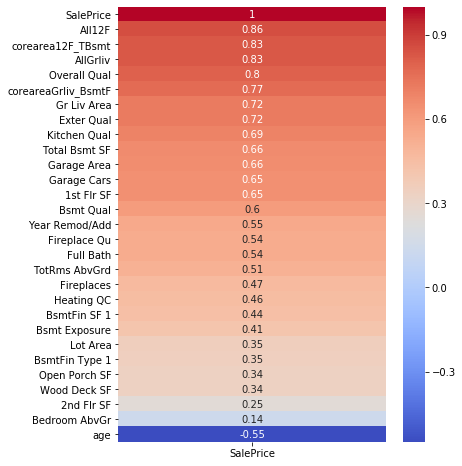

In [38]:
plt.figure(figsize=(6,8))
sns.heatmap(cleantrain.corr()[['SalePrice']].sort_values(by='SalePrice',ascending=False),annot=True,cmap='coolwarm')

`All12F` has very high correlation to `Price` and most of the other features with the exception `age` which is negatively correlated to `Price`.

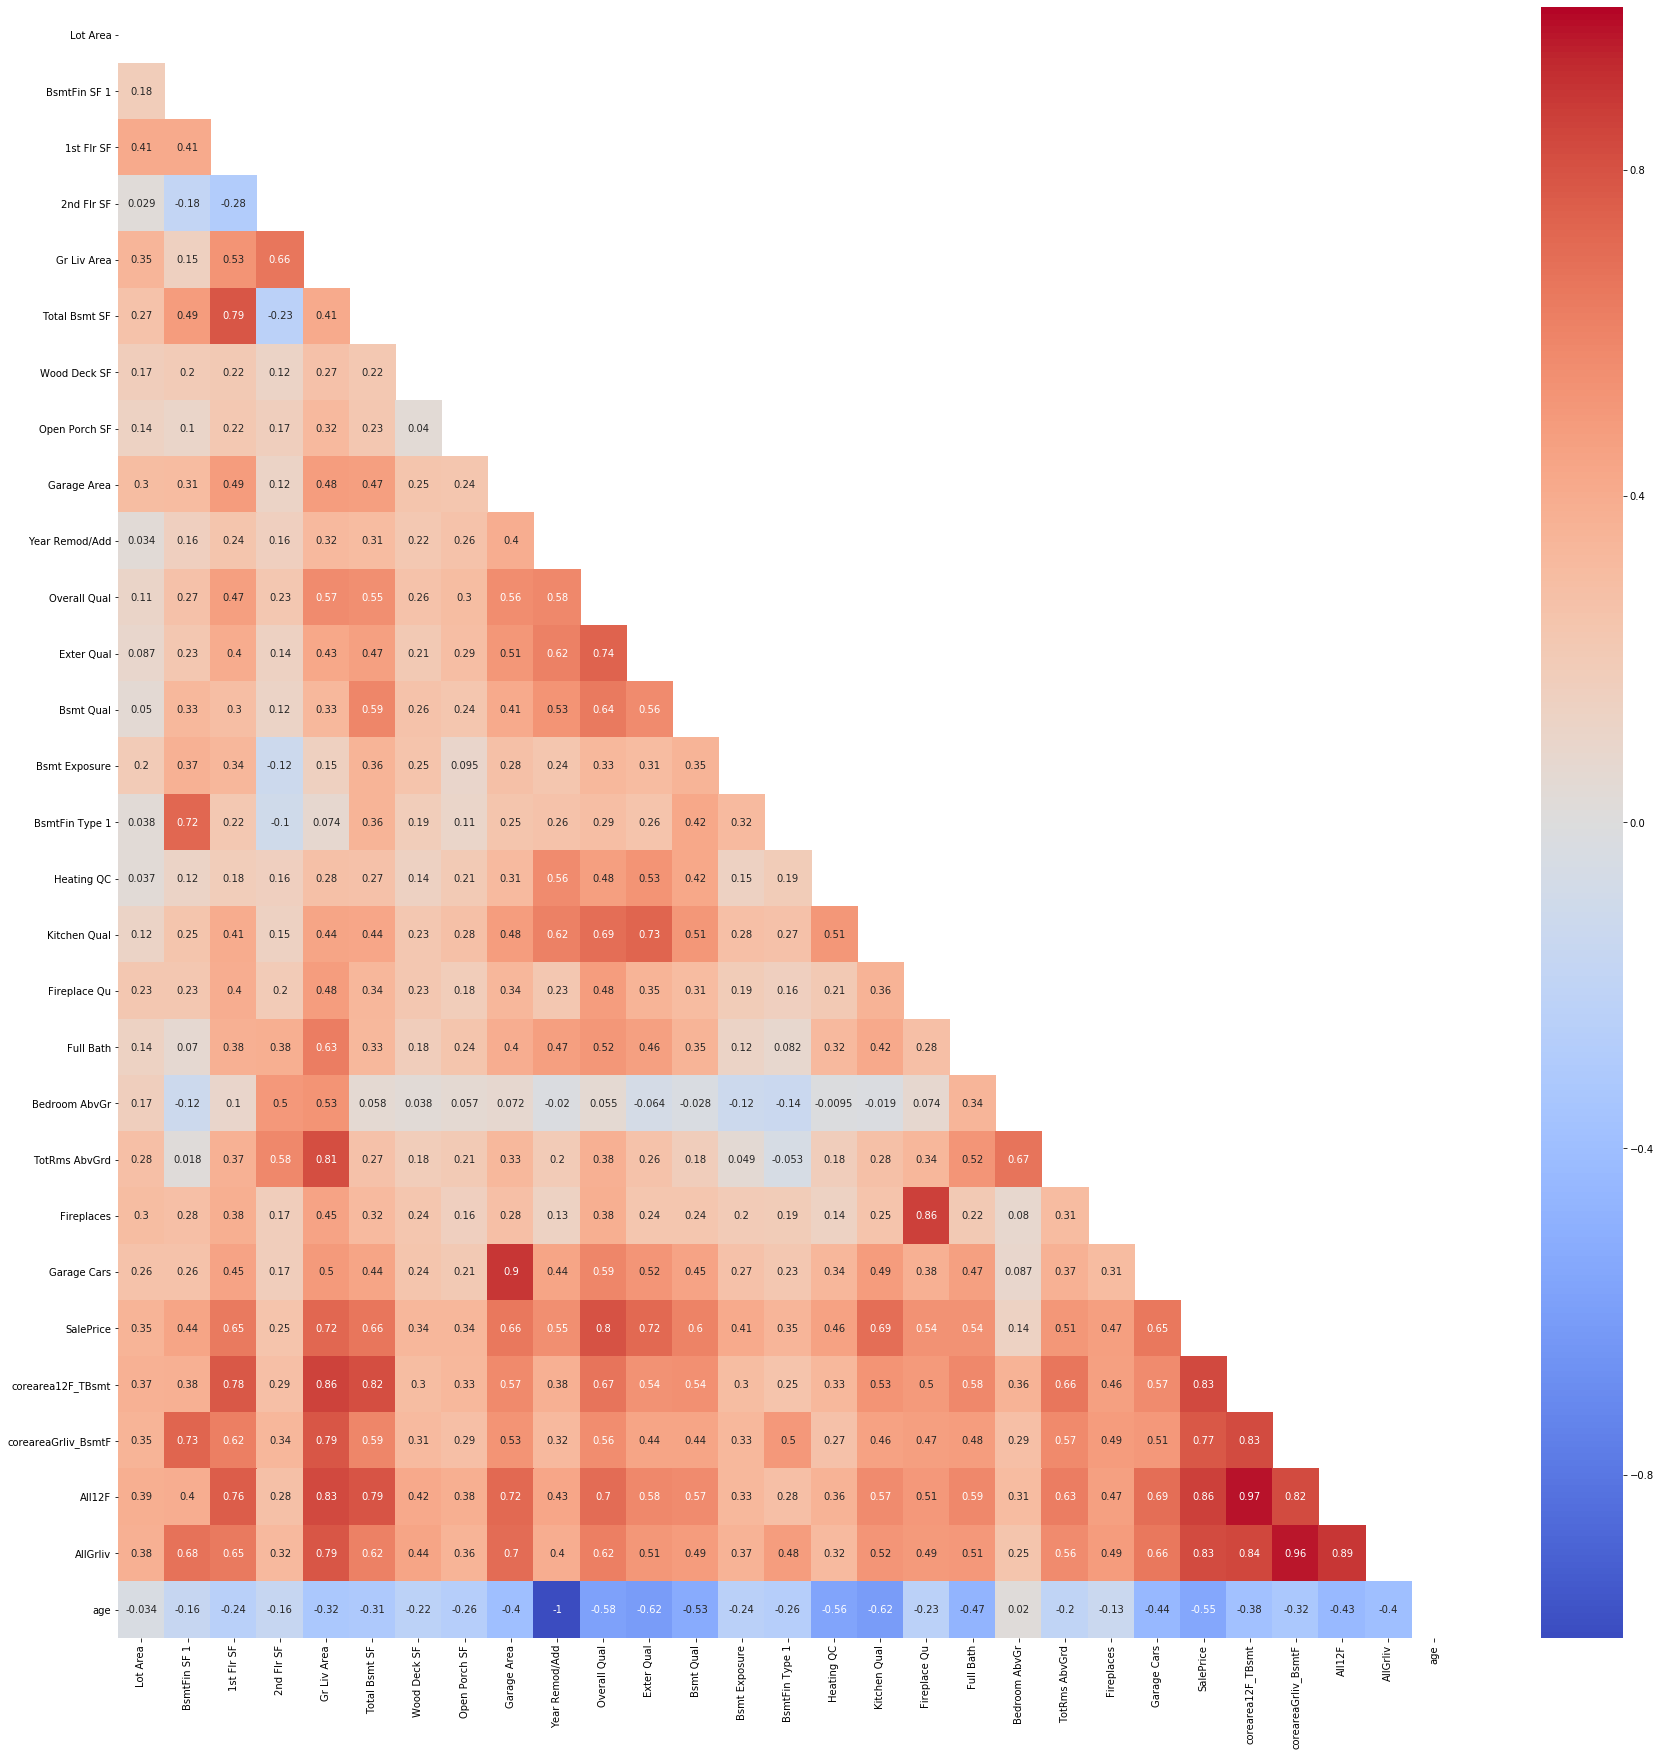

In [39]:
mask = np.zeros_like(cleantrain.corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(30,30))
sns.heatmap(cleantrain.corr(),annot=True,mask=mask, cmap='coolwarm')

Plotted the whole heatmap to see cross-correlations of the feature. 

Our top `All12F` has good predictive power but high correlation to alot of the other features because it is a blend of most of the Area related data.

<a id='7.-Embedded-method-of-feature-selection'></a>
## 7. Embedded method of feature selection

**One hot encoding to get all the rest of categorical features in**

In [40]:
final = pd.get_dummies(cleantrain,drop_first=True)

In [41]:
final.shape

(2044, 123)

### Use the below code to remove low variance features

In [42]:
def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [43]:
droppedfinal = variance_threshold_selector(final, threshold=0.05)

In [44]:
droppedfinal.shape

(2044, 62)

In [45]:
droppedfinal.columns

Index(['Lot Area', 'BsmtFin SF 1', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area',
       'Total Bsmt SF', 'Wood Deck SF', 'Open Porch SF', 'Garage Area',
       'Year Remod/Add', 'Overall Qual', 'Exter Qual', 'Bsmt Qual',
       'Bsmt Exposure', 'BsmtFin Type 1', 'Heating QC', 'Kitchen Qual',
       'Fireplace Qu', 'Full Bath', 'Bedroom AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Garage Cars', 'SalePrice', 'corearea12F_TBsmt',
       'coreareaGrliv_BsmtF', 'All12F', 'AllGrliv', 'age', 'MS SubClass_20',
       'MS SubClass_50', 'MS SubClass_60', 'Land Contour_Lvl',
       'Neighborhood_CollgCr', 'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_NAmes', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_Sawyer', 'Neighborhood_Somerst', 'House Style_1Story',
       'House Style_2Story', 'Exterior 1st_HdBoard', 'Exterior 1st_MetalSd',
       'Exterior 1st_Plywood', 'Exterior 1st_VinylSd', 'Exterior 1st_Wd Sdng',
       'Exterior 2nd_HdBoard', 'Exterior 2

In [46]:
# Dropped correlated features particularly to All12F

droppedfinal = droppedfinal[['Garage Area', 'Year Remod/Add', 'Overall Qual', 'Exter Qual', 'Kitchen Qual',
       'Fireplace Qu', 'Full Bath', 'SalePrice','All12F','MS SubClass_20',
       'MS SubClass_50', 'MS SubClass_60', 'Land Contour_Lvl',
       'Neighborhood_CollgCr', 'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_NAmes', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_Sawyer', 'Neighborhood_Somerst','Exterior 1st_HdBoard', 'Exterior 1st_MetalSd',
       'Exterior 1st_Plywood', 'Exterior 1st_VinylSd', 'Exterior 1st_Wd Sdng',
       'Exterior 2nd_HdBoard', 'Exterior 2nd_MetalSd', 'Exterior 2nd_Plywood',
       'Exterior 2nd_VinylSd', 'Exterior 2nd_Wd Sdng', 'Foundation_CBlock',
       'Foundation_PConc', 'Garage Type_Attchd', 'Garage Type_BuiltIn',
       'Garage Type_Detchd', 'Garage Type_N.A', 'Garage Finish_N.A',
       'Garage Finish_RFn', 'Garage Finish_Unf']]

In [47]:
droppedfinal.shape

(2044, 40)




**Manual dropping features due to correlation**



<br>**62-> 40 drops 1/3 of the features based on correlation**

In [48]:
features = [col for col in droppedfinal.columns if col != 'SalePrice']
X = droppedfinal[features]
y = droppedfinal['SalePrice']

In [49]:
X.head()

,Garage Area,Year Remod/Add,Overall Qual,Exter Qual,Kitchen Qual,Fireplace Qu,Full Bath,All12F,MS SubClass_20,MS SubClass_50,MS SubClass_60,Land Contour_Lvl,Neighborhood_CollgCr,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_NAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Sawyer,Neighborhood_Somerst,Exterior 1st_HdBoard,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 2nd_HdBoard,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Foundation_CBlock,Foundation_PConc,Garage Type_Attchd,Garage Type_BuiltIn,Garage Type_Detchd,Garage Type_N.A,Garage Finish_N.A,Garage Finish_RFn,Garage Finish_Unf
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
109,475.0,2005,6,4,4,0,2,2723.0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0
544,559.0,1997,7,4,4,3,2,3668.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
153,246.0,2007,5,3,4,0,1,2412.0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1
318,400.0,2007,5,3,3,0,2,2328.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
255,484.0,1993,6,3,3,0,2,2664.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


In [50]:
X.shape

(2044, 39)

In [51]:
X_train, X_test, y_train, y_test  = train_test_split(X,y)

In [52]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

## Lasso Regression for feature selection to force drop features

In [53]:
optimal_lasso = LassoCV(n_alphas=200, cv=10)
optimal_lasso.fit(X_train_sc, y_train)

print(optimal_lasso.alpha_)

159.24639456657377


In [54]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X_train_sc, y_train, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

[0.89620311 0.87069067 0.82008561 0.88464575 0.88042203 0.84863894
 0.86057631 0.85967383 0.84103538 0.84493877]
0.8606910404657816


In [55]:
lasso.fit(X_train_sc,y_train)

Lasso(alpha=159.24639456657377, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [56]:
y_pred = lasso.predict(X_test_sc)

In [57]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 20499.28100515536
Root Mean Squared Error: 28429.900358721596


In [58]:
lasso.score(X_test_sc,y_test)

0.8596616816441869

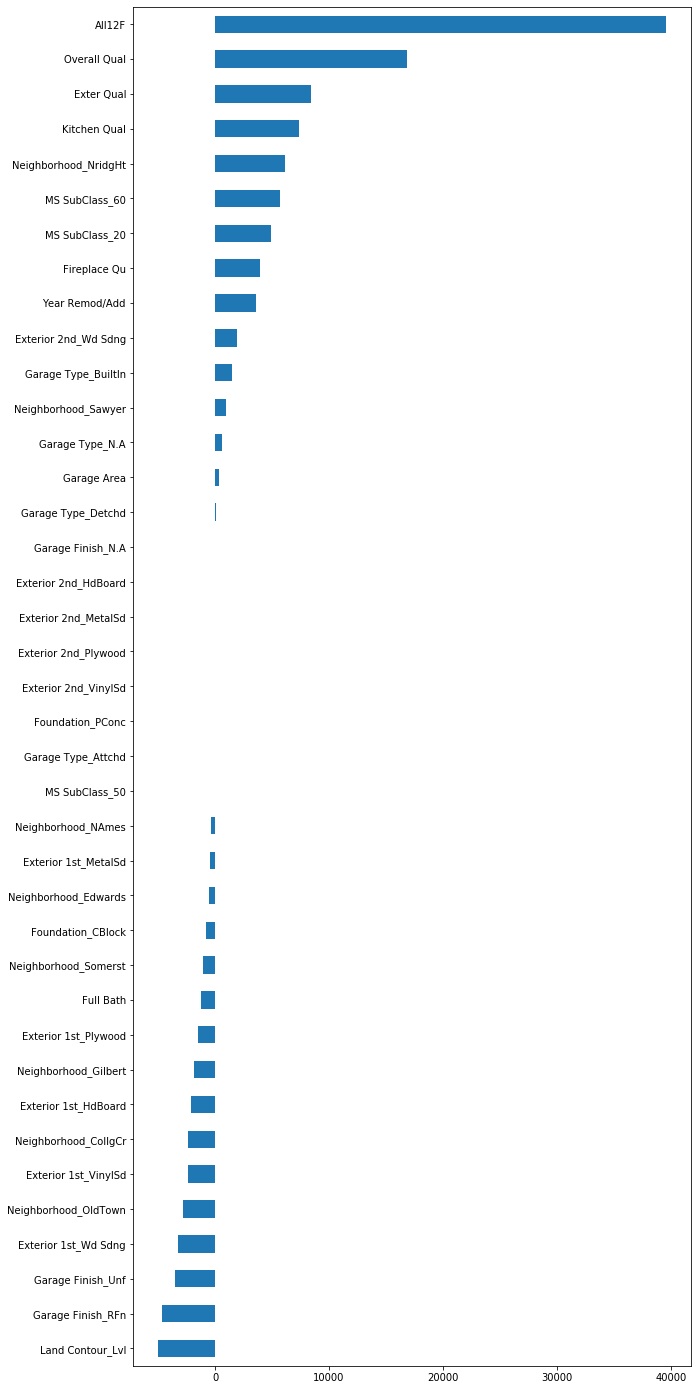

In [59]:
pd.Series(lasso.coef_, index=features).sort_values(ascending=True).plot.barh(figsize=(10,25))

### Interpretation

**Test data looks good fit as well and now there is a theme to explain to stakeholders.**

- Based on Area
- Based on Quality of the different parts of the house ie exterior, quality, type of MS Subclass
- Land Contour of house built on 
- Neighbourhood

MS Style and House Style is correlated but only flagged out after Lasso as they were categorical and heatmap did not pick up and I went up to adjust the list

In [60]:
np.count_nonzero(lasso.coef_==0)

7

In [61]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(25)

,variable,coef,abs_coef
7,All12F,39555.678059,39555.678059
2,Overall Qual,16812.218076,16812.218076
3,Exter Qual,8438.426857,8438.426857
4,Kitchen Qual,7336.530161,7336.530161
16,Neighborhood_NridgHt,6145.047109,6145.047109
10,MS SubClass_60,5696.087513,5696.087513
11,Land Contour_Lvl,-4967.502850,4967.502850
8,MS SubClass_20,4903.252763,4903.252763
37,Garage Finish_RFn,-4693.765562,4693.765562
5,Fireplace Qu,3977.332068,3977.332068


In [62]:
cleanedlasso = lasso_coefs.head(25)

In [63]:
# reassign back the list from cleanedridge to extract it from final
cleanedlasso = final[cleanedlasso['variable']].copy()

In [64]:
features = [col for col in cleanedlasso.columns if col != 'SalePrice']
X = cleanedlasso
y = final['SalePrice']

In [65]:
X_train, X_test, y_train, y_test  = train_test_split(X,y)

In [66]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [67]:
optimal_lasso2 = LassoCV(n_alphas=200, cv=10)
optimal_lasso2.fit(X_train_sc, y_train)

print(optimal_lasso2.alpha_)

67.78568279998626


In [68]:
lasso2 = Lasso(alpha=optimal_lasso2.alpha_)

lasso2_scores = cross_val_score(lasso2, X_train_sc, y_train, cv=10)

print(lasso2_scores)
print(np.mean(lasso2_scores))

[0.84750049 0.84056233 0.87960315 0.85685096 0.85943561 0.87263875
 0.86124612 0.84690788 0.84951084 0.86806602]
0.8582322153474738


In [69]:
lasso2.fit(X_train_sc,y_train)

Lasso(alpha=67.78568279998626, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [70]:
y_pred = lasso2.predict(X_test_sc)

In [71]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 21077.54752440017
Root Mean Squared Error: 28842.130552054066


In [72]:
r2 = lasso2.score(X_test_sc,y_test)
r2

0.868750606428135

In [73]:
Adj_r2 = 1-(1-r2)*(2044-1)/(2044-25-1)

Adj_r2

0.8671246228605944

## Ridge Regression

In [74]:
r_alphas = np.logspace(0, 5, 200)
ridge_model = RidgeCV(alphas=r_alphas,cv=5)
ridge_model = ridge_model.fit(X_train_sc, y_train)

In [75]:
# Here is the optimal value of alpha
ridge_optimal_alpha = ridge_model.alpha_
ridge_optimal_alpha

13.509935211980272

In [76]:
ridge = Ridge(alpha=ridge_optimal_alpha)

ridge_scores = cross_val_score(ridge, X_train_sc, y_train, cv=5)

print(ridge_scores)
print(np.mean(ridge_scores))

[0.84619482 0.86891325 0.86904514 0.85487276 0.86013238]
0.8598316702520273


In [77]:
ridge.fit(X_train_sc,y_train)

Ridge(alpha=13.509935211980272, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [78]:
y_pred = ridge.predict(X_test_sc)

In [79]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 21075.14177680771
Root Mean Squared Error: 28847.07001728537


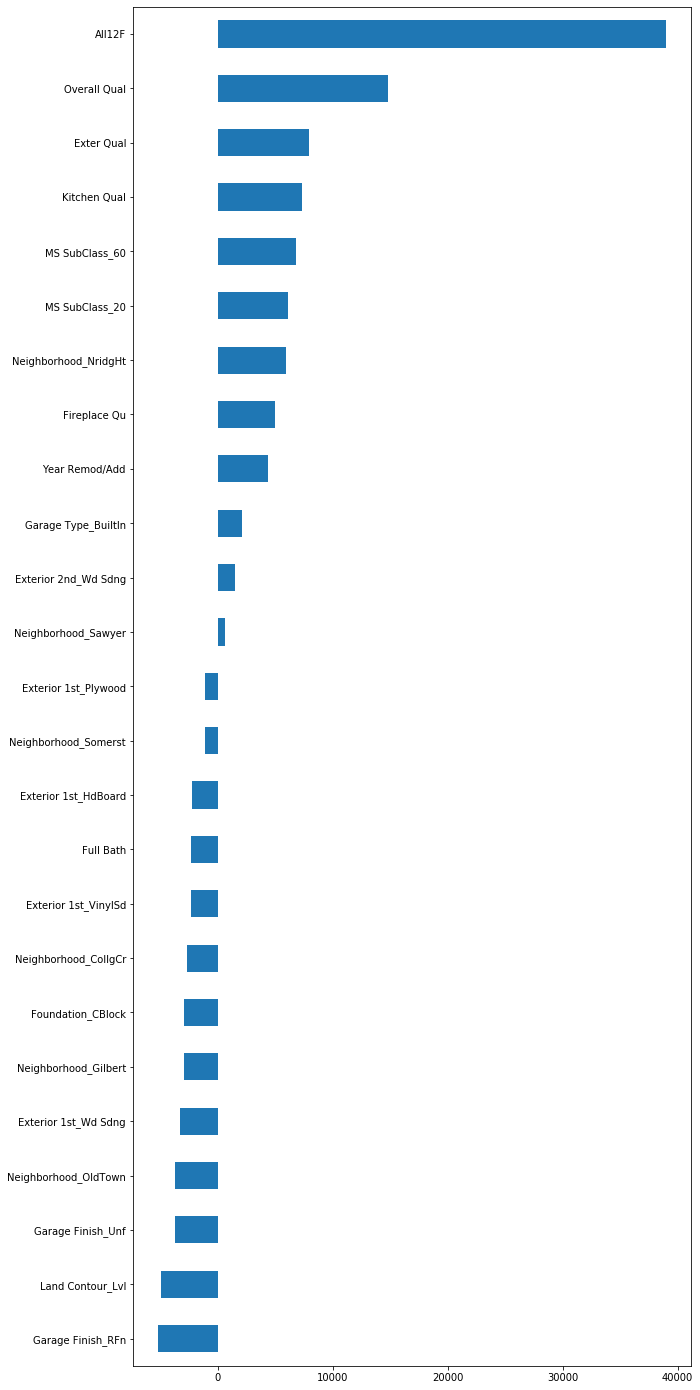

In [80]:
pd.Series(ridge.coef_, index=features).sort_values(ascending=True).plot.barh(figsize=(10,25))

In [81]:
ridge_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':ridge.coef_,
                            'abs_coef':np.abs(ridge.coef_)})

ridge_coefs.sort_values('abs_coef', inplace=True, ascending=False)

ridge_coefs.head(25)

,variable,coef,abs_coef
0,All12F,38971.612847,38971.612847
1,Overall Qual,14803.065756,14803.065756
2,Exter Qual,7961.835227,7961.835227
3,Kitchen Qual,7387.014684,7387.014684
5,MS SubClass_60,6798.832759,6798.832759
7,MS SubClass_20,6086.015946,6086.015946
4,Neighborhood_NridgHt,5924.580223,5924.580223
8,Garage Finish_RFn,-5139.650890,5139.650890
9,Fireplace Qu,4982.289656,4982.289656
6,Land Contour_Lvl,-4952.194986,4952.194986


**I tried rerunning the workbook a few times and the features in the top 30 is rather stable.**


In [82]:
cleanedridge = ridge_coefs.head(25)

In [83]:
# reassign back the list from cleanedridge to extract it from final
cleanedridge = final[cleanedridge['variable']].copy()

In [84]:
features = [col for col in cleanedridge.columns if col != 'SalePrice']
X = cleanedridge
y = final['SalePrice']

In [85]:
X_train, X_test, y_train, y_test  = train_test_split(X,y)

In [86]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [87]:
r_alphas = np.logspace(0, 5, 200)
ridge_model2 = RidgeCV(alphas=r_alphas,cv=5)
ridge_model2 = ridge_model2.fit(X_train_sc, y_train)

In [88]:
# Here is the optimal value of alpha
ridge_optimal_alpha = ridge_model2.alpha_
ridge_optimal_alpha

17.027691722259004

In [89]:
ridge2 = Ridge(alpha=ridge_optimal_alpha)

ridge2_scores = cross_val_score(ridge2, X_train_sc, y_train, cv=5)

print(ridge_scores)
print(np.mean(ridge_scores))

[0.84619482 0.86891325 0.86904514 0.85487276 0.86013238]
0.8598316702520273


In [90]:
ridge2.fit(X_train_sc,y_train)

Ridge(alpha=17.027691722259004, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [91]:
y_pred = ridge2.predict(X_test_sc)

In [92]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred))) 

Mean Absolute Error: 19759.21398873513
Root Mean Squared Error: 28536.748962488102


In [93]:
r2 = ridge2.score(X_test_sc,y_test)
r2

0.8612305614674258

In [94]:
Adj_r2 = 1-(1-r2)*(2044-1)/(2044-25-1)

Adj_r2

0.8595114157968042

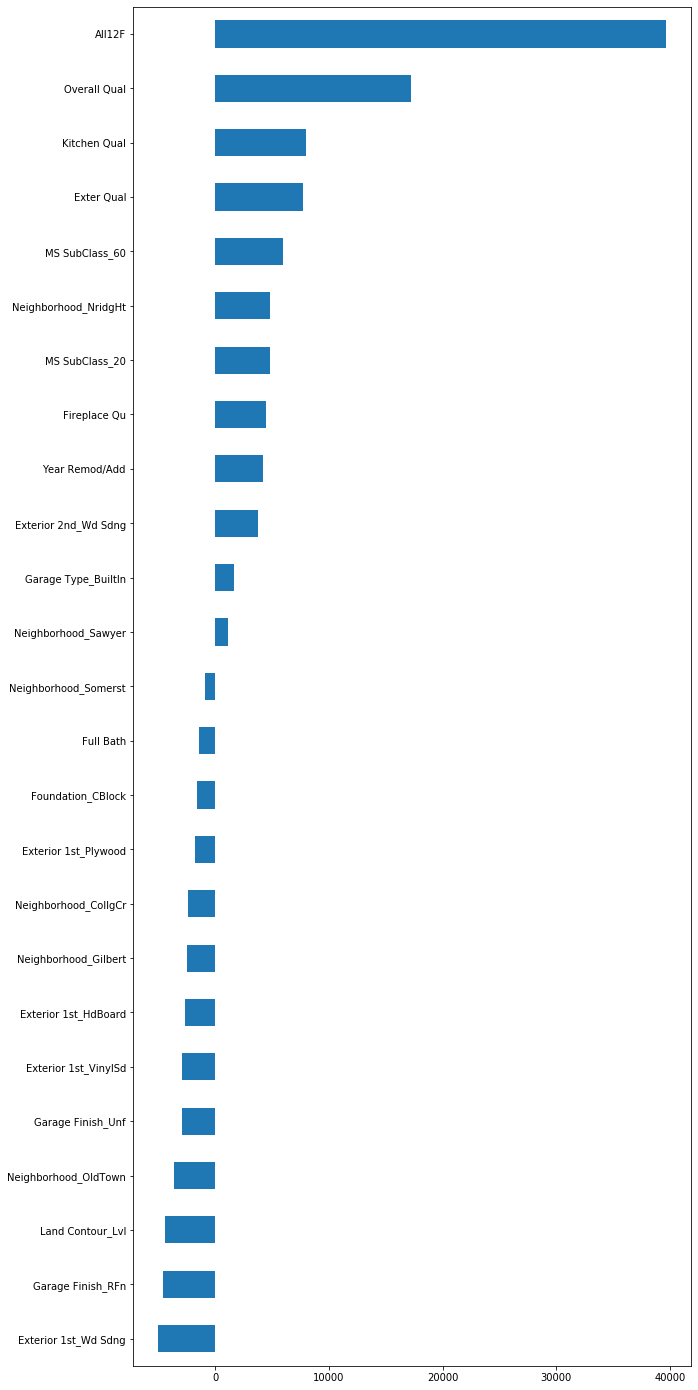

In [95]:
pd.Series(ridge2.coef_, index=features).sort_values(ascending=True).plot.barh(figsize=(10,25))

<a id='8.-Conclusion'></a>
## 8. Conclusion

Still prefer: Simple MLR
Using `All12F`,`Overall Qual` & `age`

**Why?**

- Based on the Historgram of Sale Price, most of the property cost >$100,000
- The deviation of the mean absolute error and root mean square error from the complicated 30 feature models does not differ that much in the grand scale of things. MLR is about 6K more in RMSE than Lasso2 or Ridge2


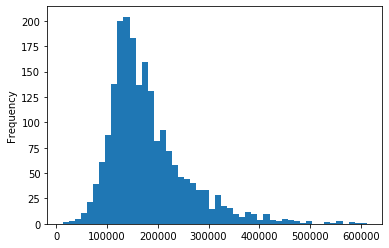

In [96]:
y.plot(kind='hist',bins=50)